# 1. 말뭉치 만들기 (한국어위키) [reference](https://paul-hyun.github.io/vocab-with-sentencepiece/)

- character level
Character 단위로 vocab을 만드는 방법 입니다. 한국어 기준으로 자음[‘ㄱ’, ‘ㄴ’, …, ‘ㅎ’], 모음[‘ㅏ’, ‘ㅑ’, …, ‘ㅣ’] 단위로 vocab을 나누거나 글자[‘가’, ‘갸’, …, ‘힣’]와 같이 가능한 모든 글자 단위로 vocab을 나누는 것 입니다. 이 경우는 가능한 모든 글자를 전부 vocab으로 표현이 가능하지만 각 단어의 고유한 의미를 표현하고 있는것은 아니기 때문에 좋은 성능을 내지 못하는 경우가 많습니다.

- space level
띄어쓰기 단위로 vocab를 만드는 방법입니다. 띄어쓰기로 할 경우 한국어의 경우는 조사/어미 등으로 인해서 중복단어 문제가 발생 합니다. 가령 ‘책’이라는 단어는 문장 내에서는 [‘책이’, ‘책을’, ‘책에’, ‘책은’, …]같이 나타납니다. 이 모든 단어를 다 vocab으로 만들경우 vocab이 매우 커지게 되고 빈도수가 낮은 단어들은 잘 학습이 되지 않습니다. 대안으로 vocab을 줄이기 위해서 일정 빈도 이상이 단어만 vocab으로 만들경우는 vocab에 없는 단어는 unknown으로 처리 해야 하는 문제가 발생하기도 합니다.

- subword level
많은 단어를 처리하면서도 unknown이 발생할 확률을 줄이는 방법으로 단어의 빈도수를 계산해서 subword 단위로 쪼개는 방법입니다. 자세한 내용은 단어 분리(Subword Segmentation)를 참고하세요. 이 기능을 쉽게 처리 할수 있도록 google에서 sentencepiece라는 툴을 제공 하고 있습니다. 이 포스트에서는 subword 방법중 BPE(Byte Pair Encoding)를 사용 합니다.

In [29]:
# vocab을 만들기 위한 말뭉치가 필요
# 한국어 위키 말뭉치(pages-articles.xml.bz2)
# https://ko.wikipedia.org/wiki/%EC%9C%84%ED%82%A4%EB%B0%B1%EA%B3%BC:%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4_%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C

In [6]:
!git clone https://github.com/paul-hyun/web-crawler.git
!cd web-crawler
!pip install tqdm
!pip install pandas
!pip install bs4
!pip install wget
!pip install pymongo
!python kowiki.py

Cloning into 'web-crawler'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 75 (delta 36), reused 56 (delta 20), pack-reused 0
Receiving objects: 100% (75/75), 52.56 KiB | 5.26 MiB/s, done.
Resolving deltas: 100% (36/36), done.
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=dfd556774e1122f033d201a021710c86bbfe79609fa2699764435cec22216a1f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 13.0 MB/s eta 0:00:00
python3: can't open file '/content/kowiki.py': [Errno 2] No such file or directory


In [7]:
!ls

sample_data  web-crawler


In [13]:
import os

# web-crawler 디렉토리로 이동
os.chdir("web-crawler")

In [ ]:
!python kowiki.py

## csv -> 텍스트로 변환

In [ ]:
# 위키데이터의 경우는 본몬(text)에 제목(title) 정보를 포함하고 있어서 제목과, 본문을 둘다 저장할 경우 내용이 중복
# 그래서 본문만 저장

In [15]:
import pandas as pd

In [19]:
in_file = "/content/web-crawler/kowiki/kowiki_20240120.csv"
out_file = "kowiki.txt"

In [20]:
# 데이터를 구분하는 데 사용되는 구분자
# 유니코드 문자 '\u241D' 사용
SEPARATOR = u"\u241D"

In [21]:
df = pd.read_csv(in_file, sep=SEPARATOR, engine="python")

ParserError: field larger than field limit (131072)

In [22]:
# 필드 크기 제한 늘리기
import csv
csv.field_size_limit(2147483647)  # 더 큰 제한으로 설정, 필요한 경우 조정(2GB)

131072

`error_bad_lines=False`로 설정하면 형식 오류가 있는 라인을 무시하고 계속 진행합니다. 여러 라인 중에서 하나의 라인에서 발생한 오류 때문에 전체 파일을 읽을 수 없는 경우에 유용합니다. 즉, 해당 라인이 다소 손상되어 있어도 나머지 데이터를 읽을 수 있습니다.

따라서 `error_bad_lines=False`로 설정하면 Pandas는 형식 오류가 있는 라인을 무시하고 나머지 데이터를 계속 읽어옵니다.

In [23]:
df = pd.read_csv(in_file, sep=SEPARATOR, engine="python", error_bad_lines=False)

<ipython-input-23-a0c6fb5142eb>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(in_file, sep=SEPARATOR, engine="python", error_bad_lines=False)


In [24]:
with open(out_file, "w") as f: # with open(...) 텍스트 파일을 쓰기모드("w")로 엶
                          # 그리고 파일 핸들은 "f"에 할당
                          # with 블록 나가면 파일 자동 닫힘, f.close() 호출 불필요
  for index, row in df.iterrows(): # df.iterrows(), df 순회하며 데이터 반환(for에 대해)
    f.write(row["text"]) # title 과 text를 중복 되므로 text만 저장 함
    f.write("\n\n\n\n") # row간 구분자 사용해서 줄바꿈

# 2. Google SentencePiece 설치

In [2]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00


In [26]:
import sentencepiece as spm

In [27]:
corpus = "kowiki.txt" # 토큰화할 대상의 경로
prefix = "kowiki" # 생성될 sentencepiece모델 이름(prefix) 정의

vocab_size = 8000 # size 증가할수록 성능 좋아지고, 모델 파라미터 수 증가

In [28]:
# SentencePiece 학습 시작
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

**`spm.SentencePieceTrainer.train(...)`**: SentencePiece의 학습을 시작합니다. 여러 옵션들이 사용되어 있습니다:

    - `--input={corpus}`: 학습에 사용될 입력 파일을 지정합니다.
    - `--model_prefix={prefix}`: 생성될 모델의 이름(prefix)을 지정합니다.
    - `--vocab_size={vocab_size + 7}`: Vocabulary의 크기를 지정합니다. 7을 더하는 이유는 [PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK] 토큰을 추가하기 위함입니다.
    - `--model_type=bpe`: 모델 유형을 BPE(Byte Pair Encoding)로 지정합니다.
    - `--max_sentence_length=999999`: 문장의 최대 길이를 지정합니다.
    - `--pad_id=0 --pad_piece=[PAD]`: [PAD] 토큰을 지정합니다.
    - `--unk_id=1 --unk_piece=[UNK]`: [UNK] 토큰을 지정합니다.
    - `--bos_id=2 --bos_piece=[BOS]`: [BOS] 토큰을 지정합니다.
    - `--eos_id=3 --eos_piece=[EOS]`: [EOS] 토큰을 지정합니다.
    - `--user_defined_symbols=[SEP],[CLS],[MASK]`: 사용자 정의 토큰으로 [SEP] - 구분자, [CLS], [MASK]를 추가합니다.

이렇게 학습된 모델을 이용하여 문장을 토큰화할 수 있습니다. 생성된 모델은 `{prefix}.model` 파일에 저장됩니다.



1. `--pad_id=0 --pad_piece=[PAD]`:
   - `--pad_id=0`: 패딩 토큰의 ID를 0으로 설정합니다.
   - `--pad_piece=[PAD]`: 패딩 토큰의 실제 내용을 "[PAD]"로 설정합니다.
   - 패딩은 시퀀스의 길이를 맞추기 위해 사용되는 특별한 토큰입니다. 패딩 토큰을 사용하면 모든 시퀀스가 동일한 길이를 가지게 됩니다.

2. `--unk_id=1 --unk_piece=[UNK]`:
   - `--unk_id=1`: 알 수 없는 (unknown) 토큰의 ID를 1로 설정합니다.
   - `--unk_piece=[UNK]`: 알 수 없는 토큰의 실제 내용을 "[UNK]"로 설정합니다.
   - 알 수 없는 토큰은 모델이 학습할 때 등장하지 않은 단어에 대응하는 특별한 토큰입니다.

3. `--bos_id=2 --bos_piece=[BOS]`:
   - `--bos_id=2`: 문장의 시작 부분을 나타내는 BOS (begin of sequence) 토큰의 ID를 2로 설정합니다.
   - `--bos_piece=[BOS]`: BOS 토큰의 실제 내용을 "[BOS]"로 설정합니다.
   - BOS 토큰은 문장의 시작을 나타내며, 문장 생성 등에서 활용될 수 있습니다.

4. `--eos_id=3 --eos_piece=[EOS]`:
   - `--eos_id=3`: 문장의 끝 부분을 나타내는 EOS (end of sequence) 토큰의 ID를 3으로 설정합니다.
   - `--eos_piece=[EOS]`: EOS 토큰의 실제 내용을 "[EOS]"로 설정합니다.
   - EOS 토큰은 문장의 끝을 나타내며, 모델이 문장을 생성하는 동안 활용될 수 있습니다.

5. `--user_defined_symbols=[SEP],[CLS],[MASK]`:
   - `--user_defined_symbols`: 사용자 정의 기호를 설정하는 옵션입니다.
   - 여기서는 "[SEP]", "[CLS]", "[MASK]" 세 가지 특별한 토큰을 사용자 정의 기호로 추가했습니다.
   - "[SEP]": 문장이나 문장 구간을 나누는 용도로 사용될 수 있습니다. 예를 들어, 문장이 두 개 이상인 경우 문장 간에 구분을 위해 사용할 수 있습니다.
   - "[CLS]": 문장의 시작 부분이나 분류 작업에서 문장의 클래스를 나타내는 데 사용될 수 있습니다.
   - "[MASK]": 마스킹 작업 등에서 어떤 토큰을 가리기 위해 사용할 수 있습니다.

따라서 이러한 설정들은 모델이 학습하거나 생성할 때 특별한 역할을 하는 토큰들을 정의하는 데 사용됩니다. "CLS"와 "BOS"의 차이는 일반적으로 사용자가 정의한 의미적 차이에 따라 다를 수 있으며, 각각의 경우에 어떻게 사용되는지는 모델이 학습되는 과정이나 특정 작업에 따라 달라질 수 있습니다.

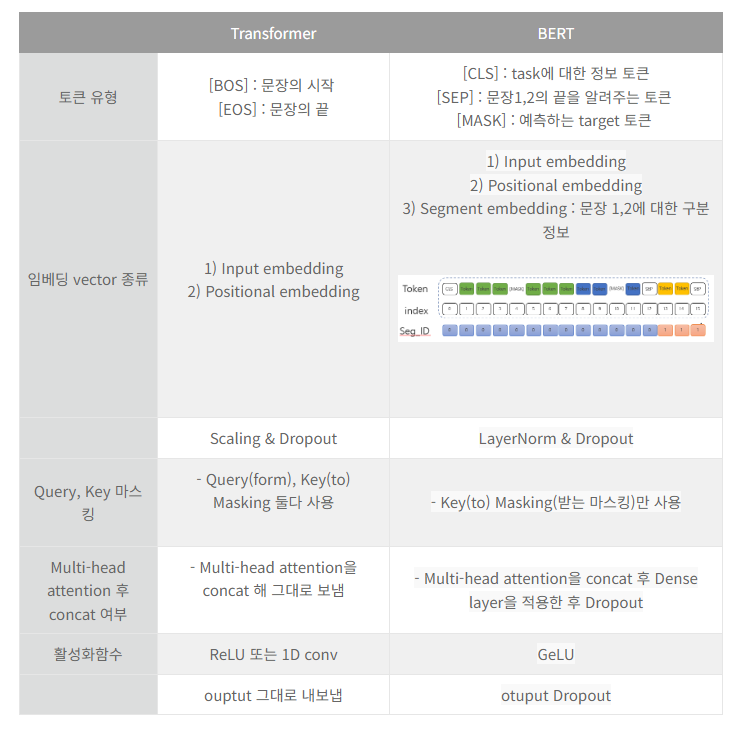

- input: 입력 corpus
- prefix: 저장할 모델 이름
- vocab_size: vocab 개수 (기본 8,000에 스페셜 토큰 7개를 더해서 8,007개)
- max_sentence_length: 문장의 최대 길이
- pad_id, pad_piece: pad token id, 값
- unk_id, unk_piece: unknown token id, 값
- bos_id, bos_piece: begin of sentence token id, 값
- eos_id, eos_piece: end of sequence token id, 값
- user_defined_symbols: 사용자 정의 토큰


In [30]:
vocab_file = "kowiki.model" # 모델파일
vocab = spm.SentencePieceProcessor()
            # SentencePiece 모델 활용해서 토큰화 수행하고 처리하는 인스턴스를 생성
vocab.load(vocab_file) # 모델 적용

lines = [ # 토큰화 할 대상 문장들
  "겨울이 돼서 날씨가 무척 추워요.",
  "이번 성탄절은 화이트 크리스마스가 될까요?",
  "겨울에 감기 조심하시고 행복한 연말 되세요."
]

for line in lines: # lines에 있는 각 문장에 대해 반복
  pieces = vocab.encode_as_pieces(line) # 각 문장을 SentencePiece 모델을 사용해서 토큰화
  ids = vocab.encode_as_ids(line) # 토큰화 해서 토큰의 id를 얻음
                                  # id는 학습될 때 자동 정의된 고유한 정수
  print(line)
  print(pieces)
  print(ids)
  print()

겨울이 돼서 날씨가 무척 추워요.
['▁겨울', '이', '▁', '돼', '서', '▁날', '씨', '가', '▁무', '척', '▁추', '워', '요', '.']
[3225, 3642, 3641, 4452, 3656, 721, 4090, 3653, 108, 4246, 199, 4011, 3811, 3644]

이번 성탄절은 화이트 크리스마스가 될까요?
['▁이번', '▁성', '탄', '절', '은', '▁화', '이트', '▁크리스', '마', '스가', '▁될', '까', '요', '?']
[2884, 91, 4023, 3978, 3658, 268, 639, 1889, 3717, 715, 1436, 3851, 3811, 4327]

겨울에 감기 조심하시고 행복한 연말 되세요.
['▁겨울', '에', '▁감', '기', '▁조', '심', '하', '시', '고', '▁행', '복', '한', '▁연', '말', '▁되', '세', '요', '.']
[3225, 3645, 193, 3660, 54, 3889, 3650, 3667, 3655, 250, 3928, 3657, 62, 3888, 481, 3736, 3811, 3644]

